# Stock Market Prediction & Forecasting using Stacked LSTM¶

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array

In [3]:
data = pd.read_csv("Stock_data.csv")
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


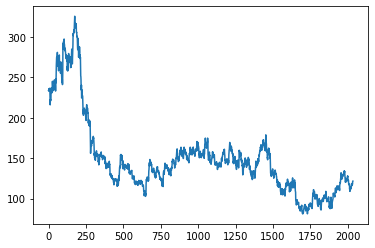

In [4]:
temp = data.reset_index()['Close']
plt.plot(temp)

# Data Transformation using Min-Max-Scaler

In [5]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [6]:
temp.shape

(2035,)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
temp = scaler.fit_transform(np.array(temp).reshape(-1,1))

In [8]:
temp.shape

(2035, 1)

# Train Test Split

In [9]:
# Doing train test split (70-30) sequencially 
data = data.sort_values(by="Date")
ntrain = int(len(temp)*0.7)
train, test = temp[0:ntrain,:], temp[ntrain:len(temp),:1]

# Convert array of values to dataset matrix
def dataset(df,time_step=1):
    dx,dy = [],[]
    for i in range(len(df)-time_step-1):
        dx.append(df[i:(i+time_step),0])
        dy.append(df[i+time_step,0])
    return np.array(dx),np.array(dy)

In [10]:
# Reshaping the Dataset in 3 parts
time_step = 50
x_train, y_train = dataset(train,time_step)
x_test, y_test = dataset(test,time_step)

# Checking the Shape
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(1373, 50) (560, 50)
(1373,) (560,)


In [11]:
# Reshaping the data to numpy array as per requirement for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# Checking the Shape
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(1373, 50, 1) (560, 50, 1)
(1373,) (560,)


# Applying LSTM Model

In [12]:
model = Sequential()
model.add(LSTM(64,return_sequences = True,input_shape = (50,1)))
model.add(LSTM(32))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))

In [13]:
model.summary()
model.compile(loss='mse',optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [14]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min",patience = 3,restore_best_weights = True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs = 15,batch_size = 32,verbose=1,callbacks =[earlystopping])

Epoch 1/15
43/43 [==============================] - 17s 122ms/step - loss: 0.0397 - val_loss: 0.0016
Epoch 2/15
43/43 [==============================] - 3s 62ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/15
43/43 [==============================] - 3s 62ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/15
43/43 [==============================] - 3s 62ms/step - loss: 0.0013 - val_loss: 9.0464e-04
Epoch 5/15
43/43 [==============================] - 3s 63ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/15
43/43 [==============================] - 3s 63ms/step - loss: 0.0013 - val_loss: 8.0540e-04
Epoch 7/15
43/43 [==============================] - 3s 62ms/step - loss: 0.0011 - val_loss: 7.3721e-04
Epoch 8/15
43/43 [==============================] - 3s 62ms/step - loss: 0.0010 - val_loss: 8.0047e-04
Epoch 9/15
43/43 [==============================] - 3s 62ms/step - loss: 9.9568e-04 - val_loss: 5.6472e-04
Epoch 10/15
43/43 [==============================] - 3s 61ms/step - loss: 9.2970e-0

# Prediction on Test Data¶

In [15]:
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

18/18 [==============================] - 0s 20ms/step


# Inverse Transformation

In [16]:
yp_train = scaler.inverse_transform(yp_train)
yp_test = scaler.inverse_transform(yp_test)

In [17]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
print(yp_train.shape,yp_test.shape)

(1373, 50, 1) (560, 50, 1)
(1373,) (560,)
(1373, 1) (560, 1)


# Evaluating the Model using metrics

In [18]:
# MAE
print("MAE for Train Data: {}".format(mean_absolute_error(y_train,yp_train)))
print("MAE for Test Data: {}\n".format(mean_absolute_error(y_test,yp_test)))

# MSE
print("MSE for Train Data: {}".format(mean_squared_error(y_train,yp_train)))
print("MSE for Test Data: {}\n".format(mean_squared_error(y_test,yp_test)))

MAE for Train Data: 166.51307559464738
MAE for Test Data: 113.90645946392269

MSE for Train Data: 30110.228312500196
MSE for Test Data: 13184.377200927544



# Plotting the Predicted Output

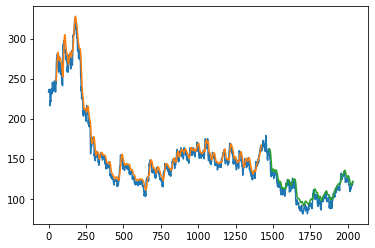

In [19]:
# Shifting train predictions for plotting
look_back=50
yp_train_plot = np.empty_like(temp)
yp_train_plot[:,:] = np.nan
yp_train_plot[look_back:len(yp_train)+look_back,:] = yp_train

# Shifting test predictions for plotting
yp_test_plot = np.empty_like(temp)
yp_test_plot[:, :] = np.nan
yp_test_plot[len(yp_train)+(look_back*2)+1:len(temp)-1,:] = yp_test

# Plotting predictions
plt.plot(scaler.inverse_transform(temp))
plt.plot(yp_train_plot)
plt.plot(yp_test_plot)
plt.show()

# Predicting & Forecasting for next 30 Days

In [20]:
x_input = test[(len(test)-50):].reshape(1,-1) # We take last 50 days data from test data for our future prediction 
temp_input = list(x_input)
temp_input = temp_input[0].tolist() # Test data

In [21]:
# Predictions for next 30 days

lstm_op = []
n_steps = 50
i = 0
while(i < 30):
    if(len(temp_input)>50):
        x_input=np.array(temp_input[1:])
        
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yp = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yp))
        
        temp_input.extend(yp[0].tolist())
        temp_input=temp_input[1:]
        lstm_op.extend(yp.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yp = model.predict(x_input,verbose=0)
        
        temp_input.extend(yp[0].tolist())
        lstm_op.extend(yp.tolist())
        i=i+1

1 day output [[0.17196634]]
2 day output [[0.17468643]]
3 day output [[0.17745821]]
4 day output [[0.18025896]]
5 day output [[0.18307301]]
6 day output [[0.18588972]]
7 day output [[0.1887018]]
8 day output [[0.19150445]]
9 day output [[0.19429506]]
10 day output [[0.19707185]]
11 day output [[0.19983386]]
12 day output [[0.2025807]]
13 day output [[0.20531231]]
14 day output [[0.20802894]]
15 day output [[0.21073109]]
16 day output [[0.21341908]]
17 day output [[0.21609353]]
18 day output [[0.21875489]]
19 day output [[0.22140361]]
20 day output [[0.22404024]]
21 day output [[0.22666551]]
22 day output [[0.22927989]]
23 day output [[0.23188375]]
24 day output [[0.23447776]]
25 day output [[0.23706245]]
26 day output [[0.23963845]]
27 day output [[0.24220611]]
28 day output [[0.24476631]]
29 day output [[0.2473193]]


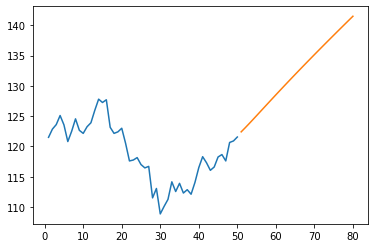

In [22]:
day_new = np.arange(1,51)
day_pred=np.arange(51,51+30)

plt.plot(day_new,scaler.inverse_transform(temp[len(temp)-50:]))
plt.plot(day_pred,scaler.inverse_transform(lstm_op))

# Conclusion

Used Stacked LSTM for Stock Market Prediction & Done Forecasting for next 30 days